In [1]:
import pandas as pd
import numpy as np

In [69]:
df = pd.read_csv('data/^GSPC.csv')

In [70]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1950-01-01,16.660000,17.090000,16.650000,17.049999,17.049999,42570000
1,1950-02-01,17.049999,17.350000,16.990000,17.219999,17.219999,33430000
2,1950-03-01,17.240000,17.610001,17.070000,17.290001,17.290001,40410000
3,1950-04-01,17.340000,18.070000,17.340000,18.070000,18.070000,48250000
4,1950-05-01,18.219999,18.780001,18.110001,18.780001,18.780001,45080000


In [71]:
df['Adj Close Diff'] = df['Adj Close']/df['Adj Close'].shift()

In [5]:
df['Log Adj Close Diff'] = np.log(df['Adj Close Diff'])

In [6]:
np.exp(df['Log Adj Close Diff'].mean())**12

1.0766989707555843

In [7]:
1.03**(1/12)

1.0024662697723037

# What happens if every period I either:
* put the excess revenue (over average revenue) and put in safe investment (3%) or 
* put funds from the safe investment to reach average revenuem

In [8]:
class State():
    def __init__(self, price):
        self.invest = price
        self.invest_history = [self.invest]
        self.safe = 0
        self.safe_history = [self.safe]

    def sell(self, revenue, expected_revenue):
        # put excess revenue in safe
        excess_revenue = expected_revenue - revenue
        self.invest -= excess_revenue
        self.safe += excess_revenue

    def buy(self, revenue, expected_revenue):
        # put funds in investment
        funds = expected_revenue - revenue
        self.invest += funds
        self.safe -= funds
        


def smoothify(prices):
    diffs = prices/prices.shift()
    av = np.exp(np.mean(np.log(diffs)))
    print(av)
    state = State(prices[0])
    for diff,price in zip(diffs[1:],prices[1:]):
#         print('----------')
#         print(price)
        expected_revenue = state.invest*av - state.invest
#         print(expected_revenue)
        revenue = state.invest*diff - state.invest
#         print(revenue)
        state.invest *= av
#         print(state.invest)
        state.invest_history.append(state.invest)
        state.safe *= 1.0024
#         print(state.safe)
        state.safe_history.append(state.safe)
        excess_revenue = expected_revenue - revenue
        state.safe += excess_revenue

    return state
            
state = smoothify(df['Adj Close'])
        
            

1.0061773224372066


In [9]:
s = pd.Series(state.invest_history)

In [10]:
(s/s.shift()).mean()

1.0061773224372177

In [11]:
s_safe = pd.Series(state.safe_history)

In [12]:
import matplotlib.pyplot as plt

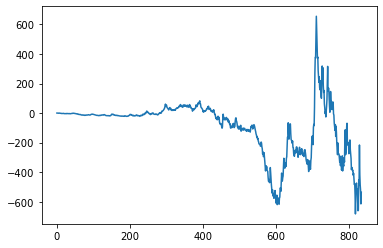

In [13]:
plt.plot(state.safe_history)

In [14]:
0.08/12

0.006666666666666667

In [15]:
df = df.dropna()

In [16]:
def min_take(sample_size=12*40, x=1000000, t=0.07):
    sample = df.sample(sample_size)
    takes = []
    for diff in sample['Adj Close Diff']:
        x*=diff
        take = x*t/12
        x-=take
        takes.append(take)
    return min(takes)

In [17]:
min_takes = [min_take() for _ in range(1000)]

In [18]:
sum(min_takes)/len(min_takes)

3617.6754068050036

(array([ 10.,  65., 117., 173., 154., 150., 133., 110.,  84.,   4.]),
 array([ 602.08549502, 1211.09958806, 1820.11368109, 2429.12777412,
        3038.14186715, 3647.15596018, 4256.17005321, 4865.18414625,
        5474.19823928, 6083.21233231, 6692.22642534]),
 <a list of 10 Patch objects>)

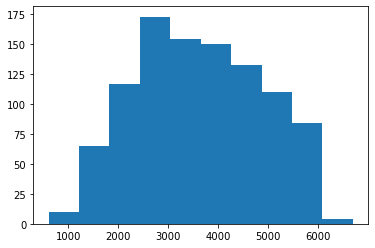

In [19]:
plt.hist(min_takes)

# Bankrupcy experiments

## Constant withdrawal

In [20]:
def is_bankrupt(t=0.05, sample_size=12*40, x=1000000):
    sample = df.sample(sample_size)
    take = x*t/12
    for diff in sample['Adj Close Diff']:
        x*=diff
        x-=take
        if x<0:
            return True
    return False

In [21]:
bankrupcies = [is_bankrupt() for _ in range(100)]

In [22]:
sum(bankrupcies)/len(bankrupcies)

0.12

In [23]:
def get_bankrupcy_prob(t, s=12*40, N=100):
    bankrupcies = [is_bankrupt(t, s) for _ in range(N)]
    return sum(bankrupcies)/len(bankrupcies)

In [24]:
bankrupcy_probs = [get_bankrupcy_prob(t) for t in [.01,.02,.03,.04,.05,.06,.07,.08,.09,.1]]

In [25]:
bankrupcy_probs

[0.0, 0.0, 0.01, 0.02, 0.05, 0.21, 0.38, 0.7, 0.68, 0.85]

## Constant percent of savings withdrawal

In [26]:
def is_bankrupt2(t=0.07, min_take_ratio=.3, sample_size=12*40, x=1000000):
    sample = df.sample(sample_size)
    min_take = min_take_ratio*x*t/12
    for diff in sample['Adj Close Diff']:
        x*=diff
        take = x*t/12
        x-=take
        if take<min_take:
            return True
    return False

In [27]:
def get_bankrupcy_prob2(t, m=.5, s=12*40, N=100):
    bankrupcies = [is_bankrupt2(t, m, s) for _ in range(N)]
    return sum(bankrupcies)/len(bankrupcies)

In [28]:
bankrupcy_probs = [get_bankrupcy_prob2(t) for t in [.01,.02,.03,.04,.05,.06,.07,.08,.09,.1]]

In [29]:
bankrupcy_probs

[0.0, 0.01, 0.01, 0.01, 0.1, 0.16, 0.28, 0.53, 0.75, 0.87]

## Flexible withdrawal

Withdraw a fixed percent down to a minimal withdrawal ratio

In [30]:
def is_bankrupt3(t=0.06, min_take_ratio=.3, sample_size=12*40, x=1000000):
    sample = df.sample(sample_size)
    min_take = min_take_ratio*x*t/12
    for diff in sample['Adj Close Diff']:
        x*=diff
        take = max(x*t/12, min_take)
        x-=take
        if x<0:
            return True
    return False

In [31]:
def get_bankrupcy_prob3(t, m=.5, s=12*40, N=100):
    bankrupcies = [is_bankrupt3(t, m, s) for _ in range(N)]
    return sum(bankrupcies)/len(bankrupcies)

In [32]:
bankrupcy_probs = [get_bankrupcy_prob3(t) for t in [.01,.02,.03,.04,.05,.06,.07,.08,.09,.1]]

In [33]:
bankrupcy_probs

[0.0, 0.0, 0.0, 0.0, 0.01, 0.0, 0.02, 0.17, 0.33, 0.52]

## Flexible withdrawal with bottom and top limits

Withdraw a fixed percent between a minimal and a maximal withdrawal limit

In [57]:
def is_bankrupt4(t=0.06, min_take_ratio=.3, sample_size=12*40, x=1000000):
    sample = df.sample(sample_size)
    min_take = min_take_ratio*x*t/12
    max_take = x*t/12
#     print(max_take)
    takes = []
    for diff in sample['Adj Close Diff']:
        x*=diff
        take = min(max(x*t/12, min_take),max_take)
        takes.append(take/max_take)
        x-=take
        if x<0:
#             print(sum(takes)/len(takes))
            return True
#     print(sum(takes)/len(takes))
    return False

In [58]:
def get_bankrupcy_prob4(t, m=.6, s=12*40, N=100):
    bankrupcies = [is_bankrupt4(t, m, s) for _ in range(N)]
    return sum(bankrupcies)/len(bankrupcies)

In [72]:
bankrupcy_probs = {t: get_bankrupcy_prob4(t) for t in [.01,.02,.03,.04,.05,.06,.07,.08,.09,.1]}

In [73]:
bankrupcy_probs

{0.01: 0.0,
 0.02: 0.0,
 0.03: 0.0,
 0.04: 0.0,
 0.05: 0.0,
 0.06: 0.01,
 0.07: 0.06,
 0.08: 0.12,
 0.09: 0.18,
 0.1: 0.35}

# Using Robert Shiller's dataset

In [75]:
df = pd.read_excel('data/ie_data.xls', sheet_name="Data", header=7, nrows=1795)

In [77]:
df['Adj Close Diff'] = df['Price.1']/df['Price.1'].shift()

In [78]:
df.tail()

,Date,P,D,E,CPI,Fraction,Rate GS10,Price,Dividend,Price.1,Earnings,Earnings.1,CAPE,Unnamed: 13,TR CAPE,Unnamed: 15,Adj Close Diff
1790,2020.03,2652.393636,59.580604,116.330000,258.115,2020.208333,0.87,2669.225749,59.958703,1.662683e+06,117.068231,72922.800031,24.817169,NaN,27.181634,NaN,0.812603
1791,2020.04,2761.975238,59.613736,110.083333,256.389,2020.291667,0.66,2798.214253,60.395909,1.746167e+06,111.527702,69596.511995,25.927359,NaN,28.407963,NaN,1.050210
1792,2020.05,2919.615000,59.646868,103.103333,256.394,2020.375000,0.67,2957.864673,60.428297,1.848936e+06,104.454083,65293.340255,27.329646,NaN,29.953171,NaN,1.058854
1793,2020.06,3104.660909,59.680000,96.490000,257.797,2020.458333,0.73,3128.217105,60.132814,1.958554e+06,97.222105,60870.044885,28.843644,NaN,31.619674,NaN,1.059287
1794,2020.07,3207.619091,NaN,NaN,259.101,2020.541667,0.62,3215.690722,NaN,2.013320e+06,NaN,NaN,29.610927,NaN,32.417381,NaN,1.027963


In [79]:
df['Adj Close Diff'].mean()**12

1.0797776206713359

In [80]:
bankrupcy_probs = {t: get_bankrupcy_prob4(t) for t in [.01,.02,.03,.04,.05,.06,.07,.08,.09,.1]}

In [81]:
bankrupcy_probs

{0.01: 0.0,
 0.02: 0.0,
 0.03: 0.01,
 0.04: 0.0,
 0.05: 0.02,
 0.06: 0.02,
 0.07: 0.15,
 0.08: 0.23,
 0.09: 0.42,
 0.1: 0.52}